<a href="https://colab.research.google.com/github/Jhsysng/AI_Model_Sec/blob/main/security/AI_SEC_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras_tuner
!pip install adversarial-robustness-toolbox
!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 56.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import keras_tuner as kt
from keras.layers import InputLayer, Dense, Conv2D, BatchNormalization, Dropout, Flatten, LeakyReLU, MaxPool2D
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from art.estimators.classification import KerasClassifier, TensorFlowV2Classifier

#기본 모델 
## Chinese Mnist 손글씨 모델 
Label:0~10,100,1000,10K, 0.1B

###전처리

In [4]:
import pandas as pd
dataset = pd.read_csv('/content/drive/MyDrive/dataset/chineseMNIST.csv')

In [5]:
X = dataset.iloc[:,:-2]
y = dataset.iloc[:,-2]

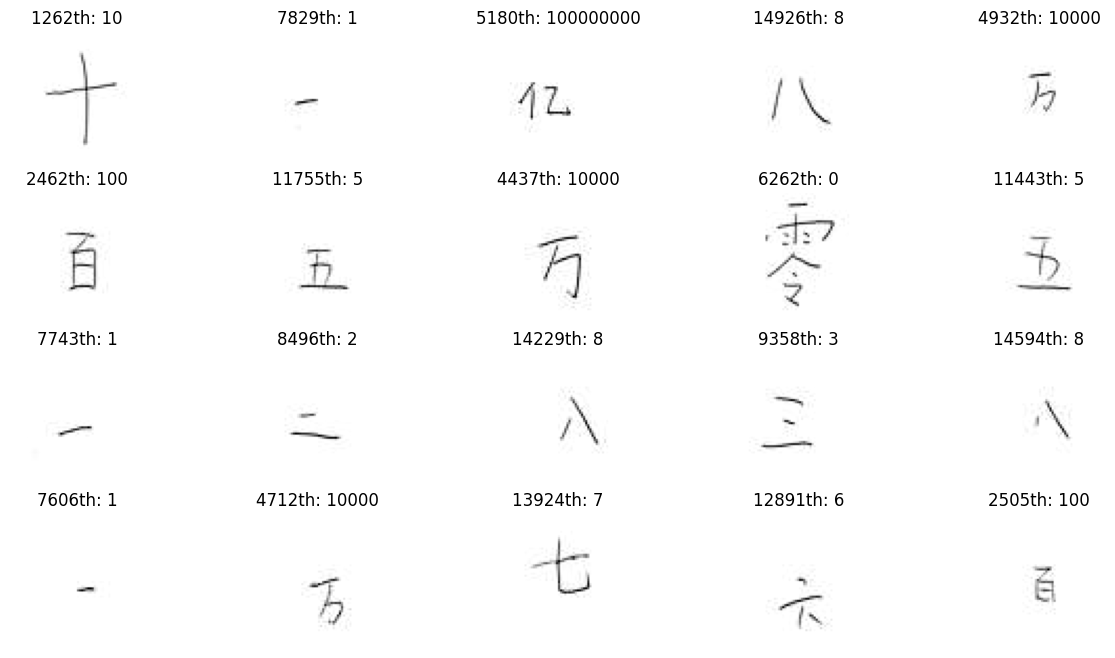

In [6]:
plt.figure(figsize=(15,8))

for i in range(20):
  plt.subplot(4,5,i+1)

  img_xy = np.random.randint(len(X))
  img = X.iloc[img_xy,:].to_numpy().reshape(64,64)
  plt.title(f"{img_xy}th: {y[img_xy]}", fontsize=12)
  plt.axis('off')
  plt.imshow(img, cmap='binary')
plt.show()

In [7]:
X.iloc[0,:].to_numpy().reshape(64,64).shape

(64, 64)

In [8]:
X = X.values    # serires to numpy
X = X.reshape((15000,64,64))
X_scaled = X/255.0
X_scaled = X_scaled[:,:,:,np.newaxis]

In [9]:
le = LabelEncoder()
y = le.fit_transform(y)

In [10]:
classes = le.classes_

In [11]:
X_scaled[0].shape

(64, 64, 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

###모델 생성 및 하이퍼파라미터 튜닝

In [13]:
def create_model(hp):
    model = keras.Sequential()
    model.add(InputLayer(input_shape=(64,64,1)))
    model.add(Conv2D(hp.Int("input_units",32,128,32),3,padding='same',activation='relu'))   # 
    model.add(MaxPool2D())
    model.add(BatchNormalization())
    drop = hp.Choice('Dropout_rate',values=[0.1,0.2,0.3])
    model.add(Dropout(drop))
    
    for i in range(hp.Int('number_of_layers',1,3,1)):
        model.add(Conv2D(hp.Int("input_units1",64,256,32),3,padding='same',activation='relu'))

    model.add(MaxPool2D())
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Flatten())
    model.add(Dense(hp.Int('input_units2',512,1024,128),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop))
    model.add(Dense(15))

    loss = SparseCategoricalCrossentropy(from_logits=True)
    opt = Adam(hp.Choice('lr',values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
    return model

In [14]:
tf.compat.v1.disable_eager_execution()
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='chinese_vuln')

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 02m 49s]
val_accuracy: 0.9629166722297668

Best val_accuracy So Far: 0.981249988079071
Total elapsed time: 00h 52m 17s


In [16]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [17]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 160)       92320     
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 160)      

###훈련

In [18]:
classifier=KerasClassifier(model=model,use_logits=False)

In [ ]:
classifier.fit(X_train, y_train, batch_size=16,nb_epochs=9 )

In [20]:
y_pred = classifier.predict(X_test)
accuracy=np.sum(np.argmax(y_pred,axis=1)==y_test)/len(y_test)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


###FGSM공격

In [21]:
from art.attacks.evasion import FastGradientMethod
attack = FastGradientMethod(estimator=classifier, eps=0.1)
x_test_adv = attack.generate(x=X_test)

In [22]:
y_pred_fgsm = classifier.predict(x_test_adv)
atk_accuracy = np.sum(np.argmax(y_pred_fgsm, axis=1)==y_test)/len(y_test)
print("accuracy {}%".format(atk_accuracy*100))

accuracy 4.2%


###모델강화
####공격샘플 훈련에 모두 참여
미리 공격후 추후 공격을 방지함에 있음

In [23]:
x_adv = attack.generate(x=X_scaled)

In [24]:
X_scaled = np.vstack((X_scaled, x_adv))
y = np.hstack((y,y))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [27]:
classifier.fit(X_train, y_train, batch_size=16,nb_epochs=9 )

Train on 24000 samples
Epoch 1/9
24000/24000 [==============================] - 40s 2ms/sample - loss: 0.1245 - accuracy: 0.9669
Epoch 2/9
24000/24000 [==============================] - 40s 2ms/sample - loss: 0.0299 - accuracy: 0.9911
Epoch 3/9
24000/24000 [==============================] - 40s 2ms/sample - loss: 0.0202 - accuracy: 0.9940
Epoch 4/9
24000/24000 [==============================] - 39s 2ms/sample - loss: 0.0237 - accuracy: 0.9930
Epoch 5/9
24000/24000 [==============================] - 39s 2ms/sample - loss: 0.0153 - accuracy: 0.9950
Epoch 6/9
24000/24000 [==============================] - 39s 2ms/sample - loss: 0.0132 - accuracy: 0.9956
Epoch 7/9
24000/24000 [==============================] - 39s 2ms/sample - loss: 0.0148 - accuracy: 0.9952
Epoch 8/9
24000/24000 [==============================] - 39s 2ms/sample - loss: 0.0128 - accuracy: 0.9959
Epoch 9/9
24000/24000 [==============================] - 39s 2ms/sample - loss: 0.0111 - accuracy: 0.9965


In [28]:
# enhanced
y_pred_en = classifier.predict(X_test)
en_accuracy = np.sum(np.argmax(y_pred_en, axis=1)==y_test)/len(y_test)
print("enhanced model accuracy{}%".format(en_accuracy*100))

enhanced model accuracy99.25%


####공격샘플 랜덤 참여
경량화

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

In [34]:
classifier.fit(X_train, y_train, batch_size=16,nb_epochs=9 )

Train on 9000 samples
Epoch 1/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0114 - accuracy: 0.9968
Epoch 2/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0090 - accuracy: 0.9977
Epoch 3/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0046 - accuracy: 0.9984
Epoch 4/9
9000/9000 [==============================] - 14s 2ms/sample - loss: 0.0036 - accuracy: 0.9992
Epoch 5/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0017 - accuracy: 0.9998
Epoch 6/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0013 - accuracy: 0.9998
Epoch 7/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0049 - accuracy: 0.9983
Epoch 8/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0055 - accuracy: 0.9986
Epoch 9/9
9000/9000 [==============================] - 15s 2ms/sample - loss: 0.0069 - accuracy: 0.9980
